### 실습 목차
* 1. BART pre-training
  * 1-1. Token Masking
  * 1-2. Token Deletion
  * 1-3. Text Infilling
  * 1-4. Sentence Permutation
  * 1-5. Document Rotation

In [ ]:
# !wget –no-check-certificate 'https://docs.google.com/uc?export=download&id=14s5orP5j6nNOqdmGdy6DkdyhcIsn-6Zv' -O ./dataset/finance_summarization/train.csv

In [10]:
import os
import random
import pandas as pd

from tqdm import tqdm
from transformers import AutoTokenizer

In [2]:
# data loading
def load_data(dataset_dir):
    """csv file을 dataframe으로 load"""
    dataset = pd.read_csv(dataset_dir)
    return dataset

In [3]:
# Pre-training 은 train 데이터 전체로 수행
total_dataset = load_data(os.path.join('./dataset/finance_summarization', "train.csv"))
total_dataset # 데이터 확인

,document,summary
0,지방자치단체와 채용계약에 의하여 채용된 계약직공무원이 그 계약기간 만료 이전에 채용...,지방자치단체와 채용계약으로 채용된 계약직공무원이 그 계약기간 만료 전에 채용계약 해...
1,갑과 을이 대지를 각자 특정하여 매수하여 배타적으로 점유하여 왔으나분필이 되어 있지...,갑과 을이 대지를 각자 특정하여 매수하였고 이를 배타적으로 점유하였는데 특정부분에 ...
2,구 어업의 허가 및 신고 등에 관한 규칙(2013. 3. 24. 해양수산부령 제1호...,구 어업의 허가 및 신고 등에 관한 규칙 제13조 [별표 8] 제1항 (나)목에서 ...
3,가. 구 사설강습소에 관한 법률(1981.4.13. 법률 제3433호) 제3조의2 ...,"구 사설강습소에 관한 법률상 주산학원은 사무관리분야에 관한 기술계강습소에 해당하고,..."
4,[1] 헌법재판소의 위헌결정에 소급효를 인정하는 것은 개별 사건에서 정의 내지 평등...,헌법재판소의 위헌결정에 소급효를 인정하는 것은 입법적 선택이므로 헌법재판소법 제47...
...,...,...
495,[1] 보험계약 당시에 보험계약자 또는 피보험자가 고의 또는 중대한 과실로 인하여 ...,보험계약당시에 고의 또는 중대한 과실로 중요한 사항을 고지하지 않거나 부실의 고지가...
496,"[1] 청소년보호법 제2조 제1호에서 ""청소년이라 함은 만 19세 미만의 자를 말한...",청소년보호법의 적용을 받는 청소년인지 여부를 판단함에 있어서는 호적 등의 공부상의 ...
497,가. 구 소득세법(1982.12.21 법률 제3576호로 개정되기 전의 것) 제27...,토지의 양도로 인한 그 양도시기는 계약금 이외의 대가의 일부인 중도금을 영수한 때로...
498,[1] 사해행위의 취소는 취소소송의 당사자 사이에서 상대적으로 취소의 효력이 있는 ...,"사해행위의 취소는 그 당사자 사이에서만 상대적으로 취소의 효력이 있는 것이며, 근저..."


In [4]:
# 사용할 BART 모델의 tokenizer 불러오기
tokenizer = AutoTokenizer.from_pretrained("gogamza/kobart-base-v1")
tokenizer # 'mask_token': '<mask>'

config.json:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


tokenizer.json:   0%|          | 0.00/682k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/4.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


PreTrainedTokenizerFast(name_or_path='gogamza/kobart-base-v1', vocab_size=30000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("<usr>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("<sys>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	5: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	

In [5]:
# tokenizer 의 모든 special token 들 확인하기
print(tokenizer.all_special_tokens, tokenizer.all_special_ids)

['<s>', '</s>', '<unk>', '<pad>', '<mask>'] [0, 1, 5, 3, 6]


In [6]:
# 특정 token의 ids 를 확인하기
tokenizer.get_vocab().get("<pad>")

3

In [7]:
# noise 를 추가할 문서 tokenizing
def tokenized_dataset(dataset,tokenizer, max_length):
    """ 토크나이징"""

    tokenized_senetences = tokenizer(dataset['document'].astype('category').tolist(),
                                     return_tensors = "pt",
                                     padding = True,
                                     truncation = True,
                                     max_length = max_length,
                                     add_special_tokens = True,
                                     return_token_type_ids=False, # BERT 이후 모델(RoBERTa 등) 사용할때 On
                                    )

    return tokenized_senetences

In [8]:
tokenized_text = tokenized_dataset(total_dataset, tokenizer, 128)

In [9]:
tokenized_text[0]

Encoding(num_tokens=128, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

### BART Noising

- 1-1. Token Masking
- 1-2. Token Deletion
- 1-3. Text Infilling
- 1-4. Sentence Permutation
- 1-5. Document Rotation

##### 1-1. Token Masking

Token Masking 은 BERT와 같은 Masking 방법으로 임의의 Token 을 Masking 한 후 해당 token 을 맞추는 방식으로 학습됩니다.

임의로 Token 을 Masking 해보는 함수를 구현해보고, 실제 데이터에서 Mask 된 부분을  확인해보겠습니다.

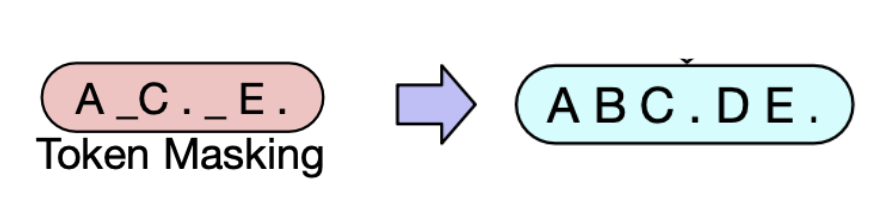

In [11]:
def token_masking(dataset, tokenizer, threshold=0.8, random_state=42):
    """
    dataset : 원본 데이터셋
    tokenizer : 토크나이저
    threshold : 문장에 마스킹을 적용할 확률의 임곅밧. 이 값보다 낮은 확률을 가진 문장에 대해서만 마스킹이 적용.
    """
    origin_data = dataset.copy()
    mask_ratio_per_sentence = 0.05 # 한 문장에서 마스킹할 토큰의 비율. 5%

    masked_YN = [] ## 마스킹 여부를 기록하는 리스트.(1 : 마스킹 O, 0 : 마스킹 X)
    masked_new_sentence = [] ## 마스킹된 문장을 저장하는 리스트
    for origin_sent in tqdm(origin_data['document'], total=origin_data.shape[0]):
        ## mask_ratio는 0에서 1 사이의 무작위 값으로, 이 값을 threshold와 비교하여 마스킹을 적용할지 결정.
        mask_ratio = random.random()
        
        ## 무작위로 생성된 mask_ratio가 threshold보다 작거나 같다면, 마스킹을 수행.
        if mask_ratio <= threshold:
            encoded_sent_ids = tokenizer(origin_sent)['input_ids'] ## 토큰화

            ## 문장의 길이에 따라 최소 1개, 최대 3개의 마스크 생성.
            sent_seq_len = len(encoded_sent_ids)
            n_masks_sent = min(3, max(1, int(sent_seq_len*mask_ratio_per_sentence))) # 한 문장당 mask 최소 1개 ~ 최대 3개

            ## 마스킹할 토큰 인덱스 선정
            mask_indices = set()
            # mask한 token 개수가 위에 지정한 전체 mask token 개수보다 적도록 반복
            while len(mask_indices)<n_masks_sent:
                mask_indices.add(random.randrange(1, sent_seq_len-1))

            ## 마스킹 적용
            for ind in list(mask_indices):
                encoded_sent_ids[ind] = 6 # 선택된 token 을 mask token으로 치환

            ## 마스킹된 문장을 디코딩하여 원래의 형태로 변환하고, 이를 masked_new_sentence 리스트에 추가
            new_sentence = tokenizer.decode(encoded_sent_ids).replace('<s>','').replace('</s>','').strip() # bos, eos token 을 치환
            masked_new_sentence.append(new_sentence)

            # mask 가 된 문장인지 확인
            masked_YN.append(1)
            
        else:
            masked_new_sentence.append(origin_sent)
            # mask 가 된 문장인지 확인
            masked_YN.append(0)

    origin_data['document_masking'] = masked_new_sentence
    origin_data['MASK_YN'] = masked_YN

    origin_data = origin_data.reset_index(drop=True)

    return origin_data

In [12]:
token_dataset = token_masking(total_dataset, tokenizer)

  0%|          | 0/500 [00:00<?, ?it/s]2024-08-29 15:33:40.400669: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-29 15:33:40.476090: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-29 15:33:40.771931: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:
2024-08-29 15

In [13]:
token_dataset[token_dataset['MASK_YN'] == 1]['document_masking'].iloc[0]

'지방자치단체와 채용계약에 의하여 채용된 계약직공무원이 그 계약기간 만료 이전에 채용계약 해지 등의 불이익을 받은 후 그 계약기간이 만료된 때에는 그 채용계약 해지의 의사표시가 무효라고 하더라도,지방공무원법이나 지방계약직공무원규<mask> 등에서 계약기간이 만료되는 계약직공무원에 대한 재계약<mask>무를 부여하는 근거규정이 없으므로 계약기간의 만료로 당연히 계약직공무원의 신분을 상실하고계약직공무원의 신분을 회복할 수 없는 것이므로,그 해지의사표시의 무효확인청구는 과거의 법률관계의 확인청구에 지나지 않는다 할 것이고,한편 과거의 법률관계라 할지라도 현재의 권리 또는 법률상 지<mask> 영향을 미치고 있고 현재의 권리 또는 법률상 지위에 대한 위험이나 불안을 제거하기 위하여 그 법률관계에 관한 확인판결을 받는 것이 유효 적절한 수단이라고 인정될 때에는 그 법률관계의 확인소송은 즉시확정의 이익이 있다고 보아야 할 것이나,계약직공무원에 대한 채용계약이 해지된 경우에는 공무원 등으로 임용되는 데에 있어서 법령상의 아무런 제약사유가 되지 않을 뿐만 아니라,계약기간 만료 전에 채용계약이 해지된 전력이 있는 사람이 공무원 등으로 임용되는 데에 있어서 그러한 전력이 없는 사람보다 사실상 불이익한 장애사유로 작용한다고 하더라도 그것만으로는 법률상의 이익이 침해되었다고 볼 수는 없으므로 그 무효확인을 구할 이익이 없다.'

##### 1-2. Token Deletion

Token Deletion 은 임의의 Token 을 삭제한 후 삭제된 token을 맞추어 원래 문장을 생성하는 방식으로 학습됩니다.

임의로 Token 을 삭제 해보는 함수를 구현해보고, 실제 데이터에서 삭제된 부분을 확인해보겠습니다.

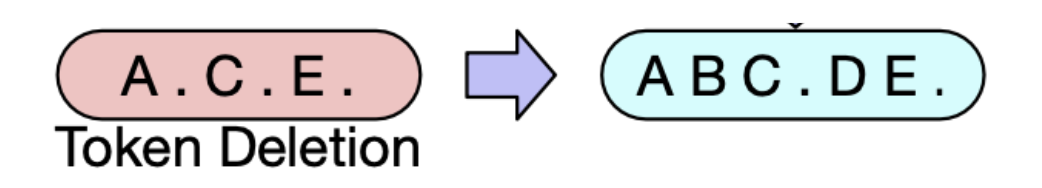

In [14]:
def token_deletion(dataset, tokenizer, threshold=0.8, random_state=22):
    origin_data = dataset.copy()

    deleted_new_sent = []
    deleted_YN = []
    deleted_token_idx = []

    for origin_sent in tqdm(origin_data['document'], total=origin_data.shape[0]):
        deletion_prop = random.random()

        # threshold 보다 작거나 같은 경우
        if deletion_prop <= threshold:
            encoded_sent_ids = tokenizer(origin_sent)['input_ids']
            sent_seq_len = len(encoded_sent_ids)
            n_masks_premise = 1

            # Deletion 할 Token index를 선택
            mask_idx = random.randrange(1, sent_seq_len-1)

            # Deletion 할 Token을 제외하고, 앞 뒤를 이어 붙인 문장 생성
            encoded_sent_ids = encoded_sent_ids[:mask_idx] + encoded_sent_ids[mask_idx+1:]

            new_sentence = tokenizer.decode(encoded_sent_ids).replace('<s>','').replace('</s>','').strip() # bos, eos token 을 치환
            deleted_token_idx.append(mask_idx)
            deleted_new_sent.append(new_sentence)
            deleted_YN.append(1)
            
        else:
            deleted_token_idx.append(-1)
            # 원본 문장 그대로 사용
            deleted_new_sent.append(origin_sent)
            deleted_YN.append(0)

    origin_data['document_deletion'] = deleted_new_sent
    origin_data['delete_YN'] = deleted_YN
    origin_data['delete_token_idx'] = deleted_token_idx

    origin_data = origin_data.reset_index(drop=True)
    
    return origin_data

In [15]:
deletion_dataset = token_deletion(total_dataset, tokenizer)

100%|██████████| 500/500 [00:00<00:00, 1331.24it/s]


In [16]:
print("원본문장:", deletion_dataset[deletion_dataset['delete_YN'] == 1].iloc[1][0])
print("삭제문장:", deletion_dataset[deletion_dataset['delete_YN'] == 1].iloc[1][2])
print("idx:", deletion_dataset[deletion_dataset['delete_YN'] == 1].iloc[1][4])
# "소외" 제거됨

원본문장: 갑과 을이 대지를 각자 특정하여 매수하여 배타적으로 점유하여 왔으나분필이 되어 있지 아니한 탓으로 그 특정부분에 상응하는 지분소유권이전등기만을 경료하였다면그 대지의 소유관계는 처음부터 구분소유적 공유관계에 있다 할 것이고,또한 구분소유적 공유관계에 있어서는 통상적인 공유관계와는 달리 당사자 내부에 있어서는 각자가 특정매수한 부분은 각자의 단독 소유로 되었다 할 것이므로,을은 위 대지 중 그가 매수하지 아니한 부분에 관하여는 갑에게 그 소유권을 주장할 수 없어 위 대지 중 을이 매수하지 아니한 부분지상에 있는 을 소유의 건물부분은 당초부터 건물과 토지의 소유자가 서로 다른 경우에 해당되어 그에 관하여는 관습상의 법정지상권이 성립될 여지가 없다.
삭제문장: 갑과 을이 대지를 각자 특정하여 매수하여 배타적으로 점유하여 왔으나분필이 되어 있지 아니한 탓으로 그 특정부분에 상응하는 지분소유권이전등기만을 경료하였다면그 대지의 소유관계는 처음부터 구분적 공유관계에 있다 할 것이고,또한 구분소유적 공유관계에 있어서는 통상적인 공유관계와는 달리 당사자 내부에 있어서는 각자가 특정매수한 부분은 각자의 단독 소유로 되었다 할 것이므로,을은 위 대지 중 그가 매수하지 아니한 부분에 관하여는 갑에게 그 소유권을 주장할 수 없어 위 대지 중 을이 매수하지 아니한 부분지상에 있는 을 소유의 건물부분은 당초부터 건물과 토지의 소유자가 서로 다른 경우에 해당되어 그에 관하여는 관습상의 법정지상권이 성립될 여지가 없다.
idx: 53


##### 1-3. Token Infilling

Text Infilling은 다수의 span(연속적인 단어들)이 샘플링되고, 각 스팬은 하나의 [MASK] 토큰으로 대체됩니다. 그리고 Decoder에서는 span에서 누락된 token을 예측하여 원래 문장을 생성하게 됩니다. 다섯가지의 noise 추가 방식 중 가장 성능이 많이 향상되는 방법입니다.

실제 문장에서 여러 개 토큰인 Span을 Mask Token으로 변경해보고, 실제 데이터에서 어떤 토큰들이 Maksing 되었는지 확인해보겠습니다.

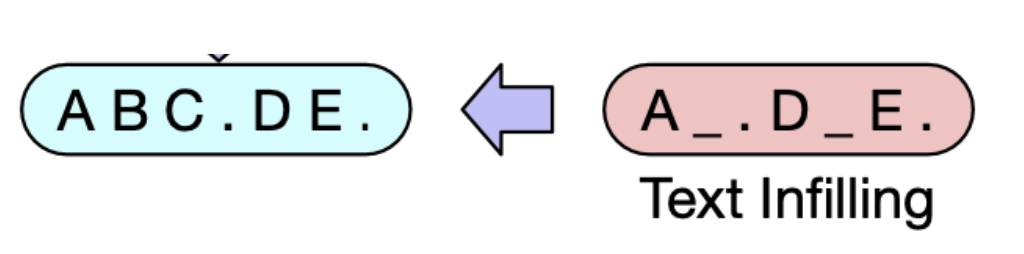

In [17]:
def token_infilling(dataset, tokenizer, threshold=0.8, random_state=218):
    origin_data = dataset.copy()
    infill_ratio_per_sentence = 0.1
    infilled_new_sent = []
    infilled_YN = []

    for origin_sent in tqdm(origin_data['document'], total=origin_data.shape[0]):
        infilling_prop = random.random()
        
        # threshold 보다 작거나 같은 경우
        if infilling_prop <= threshold:
            encoded_sent_ids = tokenizer(origin_sent)['input_ids']
            sent_seq_len = len(encoded_sent_ids)
            n_masks_sent = min(3, max(2, int(sent_seq_len*infill_ratio_per_sentence)))  # Masking한 Span의 길이는 최소 2개 ~ 최대 3개

            mask_indices_1 = random.randrange(1, sent_seq_len-n_masks_sent) # Masking의 시작위치
            mask_indices_2 = mask_indices_1 + n_masks_sent # Masking의 끝나는 위치

            ## mask_indices_1부터 mask_indices_2까지의 연속된 토큰들을 하나의 마스킹 토큰 [6]으로 대체
            ## 즉, 토큰이 여러 개여도 하나의 마스크로 치환한다.
            encoded_sent_ids = encoded_sent_ids[:mask_indices_1] + [6] + encoded_sent_ids[mask_indices_2:]

            new_sentence = tokenizer.decode(encoded_sent_ids).replace('<s>','').replace('</s>','').strip() # bos, eos token 을 치환
            infilled_new_sent.append(new_sentence)
            infilled_YN.append(1)

        else:
            infilled_new_sent.append(origin_sent)
            infilled_YN.append(0)

    origin_data['document_infilling'] = infilled_new_sent
    origin_data['infill_YN'] = infilled_YN

    origin_data = origin_data.reset_index(drop=True)

    return origin_data

In [18]:
infilling_dataset = token_infilling(total_dataset, tokenizer)

100%|██████████| 500/500 [00:00<00:00, 1300.14it/s]


In [19]:
print("원본문장:", infilling_dataset[infilling_dataset['infill_YN'] == 1].iloc[1][0])
print("변환문장:", infilling_dataset[infilling_dataset['infill_YN'] == 1].iloc[1][2])
# " 의하여 산정할 " <mask>

원본문장: 갑과 을이 대지를 각자 특정하여 매수하여 배타적으로 점유하여 왔으나분필이 되어 있지 아니한 탓으로 그 특정부분에 상응하는 지분소유권이전등기만을 경료하였다면그 대지의 소유관계는 처음부터 구분소유적 공유관계에 있다 할 것이고,또한 구분소유적 공유관계에 있어서는 통상적인 공유관계와는 달리 당사자 내부에 있어서는 각자가 특정매수한 부분은 각자의 단독 소유로 되었다 할 것이므로,을은 위 대지 중 그가 매수하지 아니한 부분에 관하여는 갑에게 그 소유권을 주장할 수 없어 위 대지 중 을이 매수하지 아니한 부분지상에 있는 을 소유의 건물부분은 당초부터 건물과 토지의 소유자가 서로 다른 경우에 해당되어 그에 관하여는 관습상의 법정지상권이 성립될 여지가 없다.
변환문장: 갑과 을이 대지를 각자 특정하여 매수하여 배타적으로 점유하여 왔으나분필이 되어 있지 아니한 탓으로 그 특정부분에 상응하는 지분소유권이전등기만을 경료하였다면그 대지의 소유관계는 처음부터 구분소유적 공유관계에 있다 할 것이고,또한 구분소유적 공유관계에 있어서는 통상적인 공유관계와는 달리 당사자 내부에 있어서는 각자가 특정매수한 부분은 각자의 단독 소유로 되었다 할 것이므로,을은 위<mask> 매수하지 아니한 부분에 관하여는 갑에게 그 소유권을 주장할 수 없어 위 대지 중 을이 매수하지 아니한 부분지상에 있는 을 소유의 건물부분은 당초부터 건물과 토지의 소유자가 서로 다른 경우에 해당되어 그에 관하여는 관습상의 법정지상권이 성립될 여지가 없다.


##### 1-4. Sentence Permutation


Sentence Permutation은 문서를 마침표 (.)를 기준으로 문장을 나눈 후, 문장들을 임의의 순서대로 섞은 후 원래 문장을 생성하는 방식입니다.

실제 여러 문장을 임의로 섞는 함수를 구현해보고, 원본 문장과 섞인 문장을 비교해보며 확인해보겠습니다.

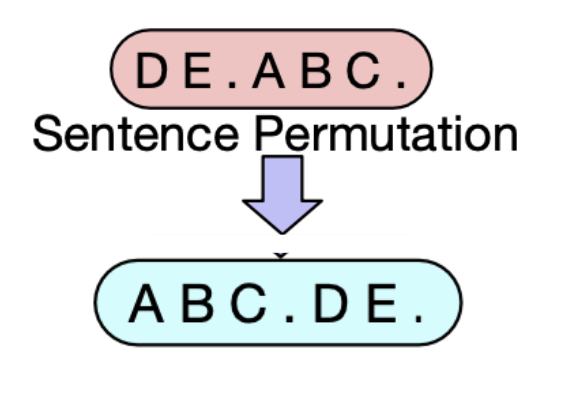



In [20]:
total_dataset['len'] = total_dataset['document'].apply(lambda x:len(x.split('.')))

In [ ]:
total_dataset[total_dataset['len'] < 2] ## 최소 2개 이상의 문장이 있어야 할 수 있다.

In [21]:
def sentence_permutation(dataset, tokenizer, random_state=218):
    origin_data = dataset.copy()

    permuted_new_doc = []
    permuted_YN = []
    for origin_sent in tqdm(origin_data['document'], total=origin_data.shape[0]):
        
        ## ⭐️ 데이터셋을 잘보고 '.'이 포함되어 있는 케이스, 날짜와 같은 패턴들은 정규표현식으로 제거해줘야 한다.
        ## 가. 와 같은 내용에서 문장 분리 방지
        origin_sent = origin_sent.replace('가. ', '가) ') # 2022. 09. 28 > 정규표현식 가. ~~~~ . @ > @. ~~~. 가

        # . 을 기준으로 문장 분할
        origin_sent = origin_sent.split('. ')

        # '' 와 같이 빈 문자열 원소 제거
        origin_sent = list(filter(None, origin_sent))

        # 문장이 2개 이상인 문서에서만 진행
        if len(origin_sent) >= 2:
            # 문장을 임의의 순서대로 섞음
            shuffle_doc = sorted(origin_sent, key=lambda k: random.random())
            
            new_doc = ". ".join(shuffle_doc)
            permuted_new_doc.append(new_doc)

            if new_doc != ". ".join(origin_sent):
                permuted_YN.append(1)
            else:
                permuted_YN.append(0) # 원본 문장이랑 같음

        else:
            permuted_new_doc.append(". ".join(origin_sent))
            permuted_YN.append(0)

    origin_data['document_permute'] = permuted_new_doc
    origin_data['permute_YN'] = permuted_YN

    origin_data = origin_data.reset_index(drop=True)
    return origin_data

In [22]:
permute_dataset = sentence_permutation(total_dataset, tokenizer)

100%|██████████| 500/500 [00:00<00:00, 224558.52it/s]


In [23]:
print("원본문장:", permute_dataset[permute_dataset['permute_YN'] == 1].iloc[4][0])
print("변환문장:", permute_dataset[permute_dataset['permute_YN'] == 1].iloc[4][3])

원본문장: 소득세법시행령(1980.12.31. 대통령령 제10120호로 개정되기 전의 것) 제115조에 의하면토지의 양도차익을 산출하기 위한 기준시가는 과세대상 토지가 (1) 취득당시와 양도당시에 모두 특정지역에 속하고그에 대한 배율이 정하여져 있는 경우에는 양도가액과 취득가액을 모두 위 시행령 제115조 제1항 제1호 (가)목의 규정에 따라 정하고,(2) 특정지역에 있는 토지로서 취득당시 특정지역에 대한 배율이 없는 경우에는 양도가액은 위 배율방법에 의하되 취득가액은 같은조 제3항의 규정에 따라 그 어느 한 시기에 특정지역에 소재하고 있지 아니하는 경우에는 양도가액과 취득가액을 모두 같은조 제1항 제1호 (나)목의 규정에 따라 정하여야 한다.
변환문장: 대통령령 제10120호로 개정되기 전의 것) 제115조에 의하면토지의 양도차익을 산출하기 위한 기준시가는 과세대상 토지가 (1) 취득당시와 양도당시에 모두 특정지역에 속하고그에 대한 배율이 정하여져 있는 경우에는 양도가액과 취득가액을 모두 위 시행령 제115조 제1항 제1호 (가)목의 규정에 따라 정하고,(2) 특정지역에 있는 토지로서 취득당시 특정지역에 대한 배율이 없는 경우에는 양도가액은 위 배율방법에 의하되 취득가액은 같은조 제3항의 규정에 따라 그 어느 한 시기에 특정지역에 소재하고 있지 아니하는 경우에는 양도가액과 취득가액을 모두 같은조 제1항 제1호 (나)목의 규정에 따라 정하여야 한다.. 소득세법시행령(1980.12.31


##### 1-5. Document Rotation

Document Rotation은 임의로 선택된 token을 기준으로 해당 token으로 시작하도록 회전한 후 원래 문장을 생성하는 방식

실제 문장들 중 임의로 토큰 하나를 선택하고, 이 토큰을 기준으로 나머지 토큰들을 회전하는 함수를 구현해보고, 원본 문장과 비교하여 확인해보겠습니다.

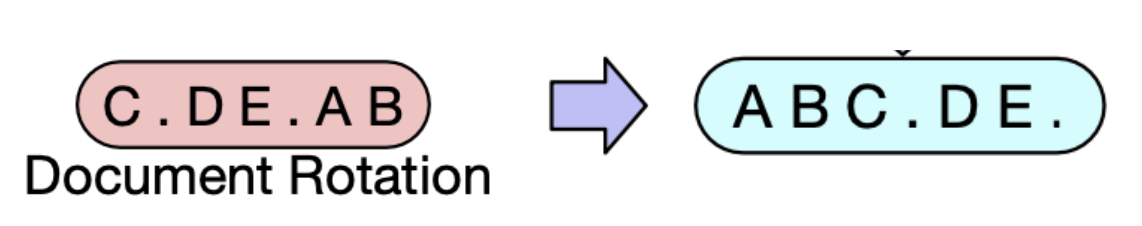

In [24]:
def document_rotation(dataset, tokenizer):
    origin_data = dataset.copy()

    rotated_sent = []
    rotated_YN = []

    for origin_sent in tqdm(origin_data['document'].tolist()):
        ## 문장을 space 기준으로 나눈다.
        splitted_sent = origin_sent.strip().split()

        seq_len = len(splitted_sent)
        ## 한 개 이상의 단어들로 구성된 문장일 때 가능
        if seq_len > 1:
            # Rotation의 기준(시작점)이 될 Token을 선택
            slicing_idx = random.randrange(1, seq_len)

            # 선택된 Token을 기준으로 회전
            rotated_sentence = ' '.join(splitted_sent[slicing_idx:] + splitted_sent[:slicing_idx])

            rotated_sent.append(rotated_sentence.strip())
            rotated_YN.append(1)

        else:
            rotated_sent.append(origin_sent)
            rotated_YN.append(0)

    origin_data['document_rotate'] = rotated_sent
    origin_data['rotate_YN'] = rotated_YN

    return origin_data

In [25]:
rotate_dataset = document_rotation(total_dataset, tokenizer)

100%|██████████| 500/500 [00:00<00:00, 78013.24it/s]


In [26]:
print("원본문장:", rotate_dataset[rotate_dataset['rotate_YN'] == 1].iloc[4][0])
print("변환문장:", rotate_dataset[rotate_dataset['rotate_YN'] == 1].iloc[4][3])

원본문장: [1] 헌법재판소의 위헌결정에 소급효를 인정하는 것은 개별 사건에서 정의 내지 평등의 원칙을 구현하는 측면이 있는 반면,법적 안정성 내지 신뢰보호의 원칙에는 배치되는 측면도 있어 그 중 어느 원칙을 보다 중시할 것인지는 원칙적으로 입법적 선택의 문제라 할 수 있고,헌법재판소법 제47조 제2항이 형벌조항에 대한 위헌결정과 비형벌조항에 대한 위헌결정의 소급효를 명문으로 달리 규정한 것도 그 때문이다.이러한 입법적 결단에도 불구하고효력이 다양할 수밖에 없는 위헌결정의 특수성 때문에 예외적으로 부분적인 소급효의 인정 또는 소급효의 제한 가능성을 부정할 수는 없다.따라서 당사자의 소급적 권리구제를 위한 구체적 타당성의 요청,소급효 인정에 따른 법적 안정성 또는 신뢰보호원칙의 침해 우려,구법에 의하여 형성된 법적 질서 혹은 기득권과 위헌결정에 따른 새로운 법적 질서의 조화 등 제반 이익을 종합적으로 고려하여,맹목적인 소급효의 인정이나 부인이 오히려 정의와 형평 등 헌법적 이념에 심히 배치되는 것으로 인정될 때에는,법문의 규정에도 불구하고소급효의 범위를 달리 정할 필요성이 인정된다.[2] 형벌조항의 경우 그 제정이나 개정 이후의 시대적·사회적 상황의 변화로 말미암아 비로소 위헌적인 것으로 평가받는 때에는 그 조항의 효력발생 시점까지 위헌결정의 전면적인 소급효를 인정하는 것이 오히려 사법적 정의에 현저히 반하는 결과를 초래할 수 있으므로,헌법재판소법 제47조 제2항 단서의 규정에도 불구하고소급효를 제한할 필요성이 있음은 비형벌조항의 경우와 크게 다르지 않다.특히 동일한 형벌조항이 과거 헌법재판소의 결정에 의하여 합헌으로 선언된 바 있음에도 그 후의 사정변경 때문에 새로 위헌으로 결정된 때에는 더욱 그러하다.그럼에도 형벌조항에 대한 위헌결정의 경우,죄형법정주의 등 헌법과 형사법하에서 형벌이 가지는 특수성에 비추어 위헌결정의 소급효와 그에 따른 재심청구권을 명시적으로 규정한 법률의 문언에 반하여 해석으로 소급효 및 피고인의 재심에 관한 권리를 제한하는 것은 허용되기 

: 